In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, f1_score, recall_score
from sklearn.preprocessing import StandardScaler


In [2]:
data=pd.read_csv("GaltonFamilies.csv" )
print(data.shape)
print(data.columns)
data.head()

(934, 9)
Index(['rownames', 'family', 'father', 'mother', 'midparentHeight', 'children',
       'childNum', 'gender', 'childHeight'],
      dtype='object')


,rownames,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,001,78.5,67.0,75.43,4,1,male,73.2
1,2,001,78.5,67.0,75.43,4,2,female,69.2
2,3,001,78.5,67.0,75.43,4,3,female,69.0
3,4,001,78.5,67.0,75.43,4,4,female,69.0
4,5,002,75.5,66.5,73.66,4,1,male,73.5


In [19]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   father           934 non-null    float64
 1   mother           934 non-null    float64
 2   midparentHeight  934 non-null    float64
 3   children         934 non-null    int64  
 4   gender           934 non-null    int64  
 5   childHeight      934 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 43.9 KB


father             0
mother             0
midparentHeight    0
children           0
gender             0
childHeight        0
dtype: int64

## Tiền xử lý

In [17]:
data = data.drop(columns=['rownames', 'family', 'childNum'])
data['gender'] = data['gender'].map({'male': 1, 'female': 0})
data.head()

,father,mother,midparentHeight,children,gender,childHeight
0,78.5,67.0,75.43,4,1,73.2
1,78.5,67.0,75.43,4,0,69.2
2,78.5,67.0,75.43,4,0,69.0
3,78.5,67.0,75.43,4,0,69.0
4,75.5,66.5,73.66,4,1,73.5


In [4]:
X = data[['father', 'mother']]
y = data['childHeight']

In [5]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra với tỷ lệ 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## mô hình hồi quy tuyến tính

In [6]:
# Tạo mô hình hồi quy tuyến tính
lr = LinearRegression()
lr.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_lr = lr.predict(X_test)

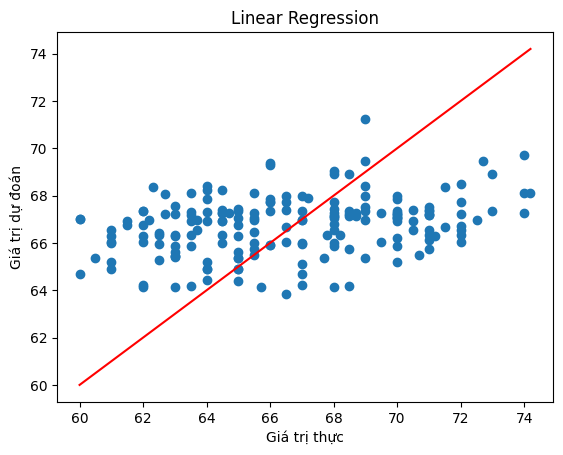

In [7]:
plt.scatter(y_test, y_pred_lr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel("Giá trị thực")
plt.ylabel("Giá trị dự đoán")
plt.title("Linear Regression")
plt.show()

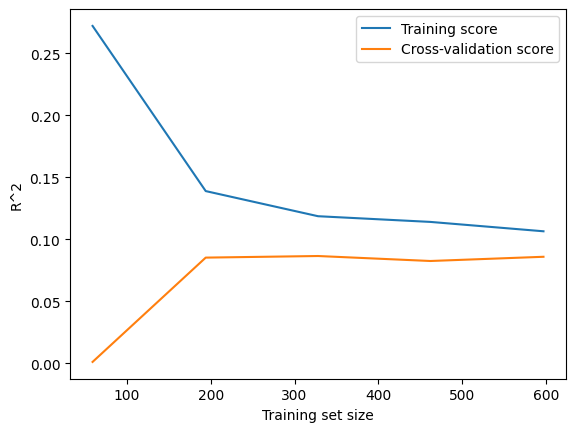

In [8]:
from sklearn.model_selection import learning_curve


train_size, train_score, test_score = learning_curve(lr, X_train, y_train, cv=5)
train_mean = np.mean(train_score, axis=1)
test_mean = np.mean(test_score, axis=1)

plt.plot(train_size, train_mean, label="Training score")
plt.plot(train_size, test_mean, label="Cross-validation score")
plt.xlabel("Training set size")
plt.ylabel("R^2")
plt.legend()
plt.show()

In [9]:
joblib.dump(lr, 'lr_model.pkl')
def evaluate_model(y_test, y_pred, model_name):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    
    print(f"--- {model_name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print()
evaluate_model(y_test, y_pred_lr, "Linear Regression") 

comparison = pd.DataFrame({'Thực tế': y_test, 'Dự đoán': y_pred_lr})
print(comparison.head(5))

--- Linear Regression ---
MSE: 10.7443
R^2: 0.0982
RMSE: 3.2778

     Thực tế    Dự đoán
321     65.5  67.060069
70      72.7  69.477979
209     70.0  67.182312
549     69.5  66.049923
711     64.0  64.917534


## mô hình hồi quy Ridge

In [10]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)


In [11]:
joblib.dump(ridge, 'ridge_model.pkl')
def evaluate_model(y_test, y_pred, model_name):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    
    print(f"--- {model_name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print()
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

comparison = pd.DataFrame({'Thực tế': y_test, 'Dự đoán': y_pred_ridge})
print(comparison.head(5))

--- Ridge Regression ---
MSE: 10.7442
R^2: 0.0982
RMSE: 3.2778

     Thực tế    Dự đoán
321     65.5  67.060009
70      72.7  69.477366
209     70.0  67.182233
549     69.5  66.050101
711     64.0  64.917968


## mô hình Neural Network

In [12]:
mlp = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
joblib.dump(mlp,'MLP.pkl')
y_pred_neural = mlp.predict(X_test)

In [13]:
def evaluate_model(y_test, y_pred, model_name):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    
    print(f"--- {model_name} ---")
    print(f"MSE: {mse:.4f}")
    print(f"R^2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print()
    
evaluate_model(y_test, y_pred_neural, "Neural Network")

comparison = pd.DataFrame({'Thực tế': y_test, 'Dự đoán': y_pred_neural})
print(comparison.head(5))

--- Neural Network ---
MSE: 11.0873
R^2: 0.0695
RMSE: 3.3298

     Thực tế    Dự đoán
321     65.5  67.162026
70      72.7  70.986350
209     70.0  67.179265
549     69.5  65.436234
711     64.0  63.693204


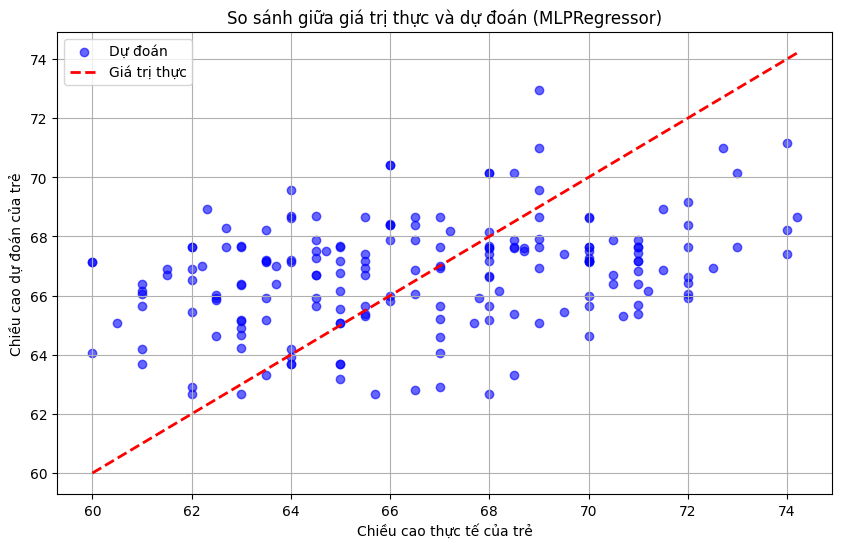

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_neural, color='blue', alpha=0.6, label="Dự đoán")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Giá trị thực")
plt.xlabel('Chiều cao thực tế ')
plt.ylabel('Chiều cao dự đoán ')
plt.title('So sánh giữa giá trị thực và dự đoán (MLPRegressor)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
base_models = [
    ('linear', lr),
    ('neural', mlp),
    ('ridge', ridge)
]
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

stacking_model.fit(X_train, y_train)

y_pred_stacking = stacking_model.predict(X_test)
joblib.dump(stacking_model,'Stacking.pkl')
# Đánh giá mô hình stacking
evaluate_model(y_test, y_pred_stacking, "Stacking")

comparison = pd.DataFrame({'Thực tế': y_test, 'Dự đoán': y_pred_stacking})
print(comparison.head(5))

--- Stacking ---
MSE: 10.8830
R^2: 0.0866
RMSE: 3.2989

     Thực tế    Dự đoán
321     65.5  66.884161
70      72.7  68.239189
209     70.0  66.905274
549     69.5  66.283594
711     64.0  65.661914
